# Fruit Image Classification using CNN

We will follow a structured approach to:
1.	Import necessary libraries.
2.	Prepare the dataset.
3.	Visualize sample images.
4.	Define the CNN architecture.
5.	Set up training and testing functions.
6.	Train the model.
7.	Evaluate the model.
8.	Make predictions on new images

## 1. Import Necessary Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

## 2. Prepare the Dataset

### 2.1. Define Functions for Data Preparation
1. Load the image file paths and corresponding labels.
2. Create functions to handle data loading and

In [2]:
def load_filepaths(target_dir):
    """
    Load file paths from the given directory and its subdirectories.
    """
    paths = []
    for root, _, files in os.walk(target_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(root, file))
    return paths

def prepare_data(target_dir):
    """
    Prepare data by collecting file paths and labels.
    Assumes that each subdirectory in target_dir corresponds to a class.
    """
    filepaths = []
    labels = []
    class_names = os.listdir(target_dir)
    # Filter out any files, only keep directories
    class_names = [d for d in class_names if os.path.isdir(os.path.join(target_dir, d))]
    class_names.sort()  # Ensure consistent class ordering
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    for cls_name in class_names:
        cls_dir = os.path.join(target_dir, cls_name)
        fpaths = load_filepaths(cls_dir)
        labels += [class_to_idx[cls_name]] * len(fpaths)
        filepaths += fpaths

    return np.array(filepaths), torch.tensor(labels), class_names

### 2.2. Load Training and Testing Data

In [3]:
# Specify the paths to your training and testing directories
train_dir = 'train'  # Replace with your actual training directory path
test_dir = 'test'    # Replace with your actual testing directory path

# Prepare training data
train_filepaths, train_labels, class_names = prepare_data(train_dir)
print("Classes:", class_names)
print(f"Number of training samples: {len(train_filepaths)}")

# Prepare testing data
test_filepaths, test_labels, _ = prepare_data(test_dir)
print(f"Number of testing samples: {len(test_filepaths)}")

Classes: ['apple', 'banana', 'mixed', 'orange']
Number of training samples: 240
Number of testing samples: 60


### 2.3. Data Transformation Function

In [ ]:
def load_images(filepaths):
    """
    Load images with augmentation for better model generalization.
    """
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])  # ImageNet statistics
    ])

    tensors = []
    for item in filepaths:
        image = Image.open(item).convert('RGB')
        img_tensor = transform(image)
        tensors.append(img_tensor.unsqueeze(0))

    return torch.cat(tensors, dim=0)

## 3. Visualize Sample Images

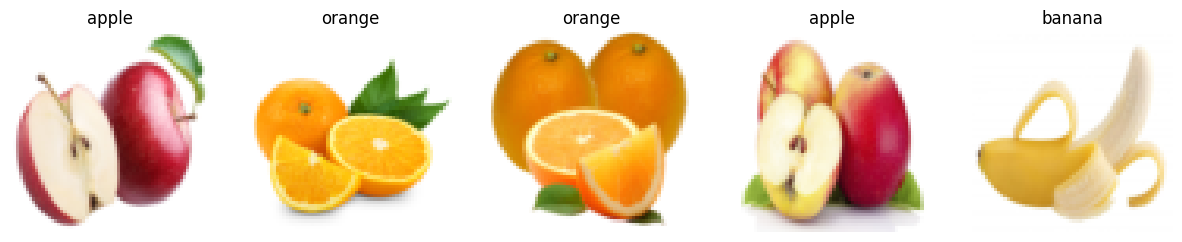

In [5]:
# Function to display images
def show_images(images, labels, class_names):
    """
    Display a batch of images with their labels.
    """
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).numpy()  # Rearrange dimensions for plotting
        axes[idx].imshow(img)
        axes[idx].set_title(class_names[label])
        axes[idx].axis('off')
    plt.show()

# Load a few images
sample_indices = np.random.choice(len(train_filepaths), size=5, replace=False)
sample_filepaths = train_filepaths[sample_indices]
sample_labels = train_labels[sample_indices]
sample_images = load_images(sample_filepaths)

# Display the images
show_images(sample_images, sample_labels, class_names)

## 4. Define the CNN Architecture

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=16*16*32, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # Convolutional layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor
        x = x.view(-1, 16 * 16 * 32)
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## 5. Set Device

In [7]:
# Device configuration for Ben
# Apple silicon macbook MPS (Metal Performance Shaders)
device = torch.device('mps' if torch.mps.is_available else 'cpu')
print(f"Using device: {device}")

Using device: mps


## 6. Define Loss Function and Optimizer

Using:
1. Cross-Entropy Loss
2. Adam Optimizer

In [8]:
# Instantiate the model
model = SimpleCNN(num_classes=len(class_names)).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 7. Define the Training Function

In [9]:
def train(model, criterion, optimizer, filepaths, labels, batch_size=32, n_epochs=10):
    """
    Train the CNN model.

    Args:
        model: The CNN model to be trained.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        filepaths: Numpy array of image file paths.
        labels: Tensor of corresponding labels.
        batch_size: Number of samples per batch.
        n_epochs: Number of training epochs.
    """
    model.train()
    total_samples = len(filepaths)
    for epoch in range(n_epochs):
        # For tracking progress
        samples_trained = 0
        running_loss = 0.0
        correct_preds = 0

        # Shuffle the data
        permutation = torch.randperm(total_samples)
        for i in range(0, total_samples, batch_size):
            indices = permutation[i : i+batch_size]
            batch_inputs = load_images(filepaths[indices])
            batch_labels = labels[indices]
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            # Forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate loss and accuracy
            running_loss += loss.item() * batch_labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == batch_labels).item()
            samples_trained += batch_labels.size(0)

            # Print progress every 10 batches
            if (i // batch_size) % 10 == 0:
                print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i//batch_size}], " +
                      f"Loss: {loss.item():.4f}")

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / samples_trained
        epoch_acc = correct_preds / samples_trained * 100
        print(f"Epoch [{epoch+1}/{n_epochs}] completed. " +
              f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%\n")

## 8. Define the Testing Function

In [ ]:
def test(model, filepaths, labels, batch_size=32):
    """
    Evaluate the CNN model on the test dataset.

    Args:
        model: The trained CNN model.
        filepaths: Numpy array of image file paths.
        labels: Tensor of corresponding labels.
        batch_size: Number of samples per batch.
    """
    model.eval()
    samples_tested = 0
    correct_preds = 0
    total_samples = len(filepaths)
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for i in range(0, total_samples, batch_size):
            batch_inputs = load_images(filepaths[i : i + batch_size])
            batch_labels = labels[i : i + batch_size]
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            # Forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            running_loss += loss.item() * batch_labels.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == batch_labels).item()
            samples_tested += batch_labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = running_loss / samples_tested
    accuracy = correct_preds / samples_tested * 100
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

## 9. Train the Model

In [11]:
# Set training parameters
n_epochs = 10
batch_size = 32

# Train the model
print("Starting training...")
train(model, criterion, optimizer, train_filepaths, train_labels, batch_size=batch_size, n_epochs=n_epochs)

Starting training...


/Users/benben/.pyenv/versions/3.12.4/envs/benmain/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Step [0], Loss: 1.3864
Epoch [1/10] completed. Loss: 1.3639, Accuracy: 25.00%

Epoch [2/10], Step [0], Loss: 1.2415
Epoch [2/10] completed. Loss: 1.2394, Accuracy: 52.50%

Epoch [3/10], Step [0], Loss: 1.1883
Epoch [3/10] completed. Loss: 1.0530, Accuracy: 69.17%

Epoch [4/10], Step [0], Loss: 0.7800
Epoch [4/10] completed. Loss: 0.8459, Accuracy: 68.33%

Epoch [5/10], Step [0], Loss: 0.6409
Epoch [5/10] completed. Loss: 0.6465, Accuracy: 81.25%

Epoch [6/10], Step [0], Loss: 0.5712
Epoch [6/10] completed. Loss: 0.5180, Accuracy: 78.75%

Epoch [7/10], Step [0], Loss: 0.3876
Epoch [7/10] completed. Loss: 0.4901, Accuracy: 81.25%

Epoch [8/10], Step [0], Loss: 0.5939
Epoch [8/10] completed. Loss: 0.4050, Accuracy: 85.00%

Epoch [9/10], Step [0], Loss: 0.3124
Epoch [9/10] completed. Loss: 0.3125, Accuracy: 89.58%

Epoch [10/10], Step [0], Loss: 0.2156
Epoch [10/10] completed. Loss: 0.2369, Accuracy: 92.08%



## 10. Evaluate the Model

In [12]:
# Test the model
print("Starting testing...")
test(model, test_filepaths, test_labels, batch_size=batch_size)

Starting testing...
Test Loss: 0.4058, Test Accuracy: 86.67%
